# 1. Load and Preprocess the Data
First, let's load the data and preprocess it, which includes normalizing the features and splitting the data into features and targets.

In [37]:
import pandas as pd
import os, shutil, math
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import models, layers
from keras import backend as K
import matplotlib.pyplot as plt

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

# Load datasets
df_train = pd.read_csv('./dataset/train/2015_2020.csv')
df_test = pd.read_csv('./dataset/test/2022_2023.csv')

# convert "DayOfWeek"
# days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# for i in days:
#   df_train["DayOfWeek"] = df_train["DayOfWeek"].replace(i, days.index(i))
#   df_test["DayOfWeek"] = df_train["DayOfWeek"].replace(i, days.index(i))

# for i in df_train["DateTime"]:
#   time = i.split(" ")[1]
#   hour = time.split(":")[0]
#   df_train["DateTime"] = df_train["DateTime"].replace(i, hour)

# for i in df_test["DateTime"]:
#   time = i.split(" ")[1]
#   hour = time.split(":")[0]
#   df_test["DateTime"] = df_train["DateTime"].replace(i, hour)


df_train.drop(["DayOfWeek"], axis=1, inplace=True)
df_test.drop(["DayOfWeek"], axis=1, inplace=True)

df_train.drop(["DateTime"], axis=1, inplace=True)
df_test.drop(["DateTime"], axis=1, inplace=True)

target_column = 'KCPL'

# Separate features and targets
features_train = df_train.drop(target_column, axis=1)
target_train = df_train[target_column]
features_test = df_test.drop(target_column, axis=1)
target_test = df_test[target_column]

# Normalize features
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)


c:\Users\Zhaoyu Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# 2. Build the FNN Model

Defines a function to create a neural network model, allowing to set different numbers of hidden layers and units, learning rate, and parameters such as regularization and dropout.

Use Keras’ Sequential model.

Adds the specified number of hidden layers, using dropout if needed.

Use the Adam optimizer and use the mean square error (MSE) as the loss function.

In [9]:
def create_model(hidden_layers, hidden_units, learning_rate, regularizer=None, dropout_rate=0.0):
    model = models.Sequential()
    model.add(layers.Dense(hidden_units, activation='relu', input_dim=features_train_scaled.shape[1], kernel_regularizer=regularizer))

    for _ in range(hidden_layers - 1):
        model.add(layers.Dense(hidden_units, activation='relu', kernel_regularizer=regularizer))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1))  # No activation for regression

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


# 3. Train and Evaluate Models

Defines a function for training and evaluating neural network models with different configurations.

The loop tried different parameter combinations such as the number of hidden layers and units, learning rate, dropout rate, regularization method, etc., and printed the training and testing MSE and MAE values of the model.

The change of the loss function with the number of iterations is plotted, which can be used to observe the training situation and generalization ability of the model.

In [3]:
# best model tracking
global bestModel
bestModel = create_model(0, 0, 0, regularizer=None, dropout_rate=0.0)
global bestMSE
bestMSE = 100000000000000000000000 #really high number
global best_hidden_layers
best_hidden_layers = 0
global best_hidden_units
best_hidden_units = 0
global best_learning_rate
best_learning_rate = 0
global best_dropout_rate
best_dropout_rate = 0
global best_regularizer
best_regularizer = None
global best_history
best_history = None

In [15]:
def drange(start, stop, step):
  while start < stop:
    yield start
    start += step

In [32]:
hidden_layers_list = []
for j in drange(1, 6, 1):
    hidden_layers_list.append(j)
# 'the optimal size of the hidden layer is usually between the size of the input and size of the output layers'
hidden_units_list = []
for j in drange(int((len(features_test_scaled) + len(target_test))/10), (len(features_test_scaled) + len(target_test)), int((len(features_test_scaled) + len(target_test))/10)):
    hidden_units_list.append(j)

learning_rate_list = []
for j in drange(0.003, 0.01, 0.002):
    learning_rate_list.append(round(j, 3))

dropout_rates = []  #  Experiment with dropout rates
for j in drange(0.4, 0.6, 0.1):
    dropout_rates.append(round(j, 1))

regularizers = [None, tf.keras.regularizers.l2(0.01)]  #  Experiment with L2 regularization

number_iterations = len(hidden_layers_list) * len(hidden_units_list) * len(learning_rate_list) * len(dropout_rates) * len(regularizers)
print(f'Number of iterations: {number_iterations}')

Number of iterations: 720


In [33]:
hidden_layers_list

[1, 2, 3, 4, 5]

In [15]:
hidden_units_list[:-3]

[3208, 6416, 9624, 12832, 16040, 19248]

In [7]:
def train_and_evaluate_models(features_train_scaled, target_train, features_test_scaled, target_test):
    count = 0
    for hidden_layers in hidden_layers_list:
        for hidden_units in hidden_units_list[:-3]:
            for learning_rate in learning_rate_list:
                for dropout_rate in dropout_rates:
                    for regularizer in regularizers:
                        count += 1
                        print(f"[{count}/{number_iterations}]: Training model with: Hidden Layers: {hidden_layers}, Hidden Units: {hidden_units}, Learning Rate: {learning_rate}, Dropout Rate: {dropout_rate}, Regularizer: {regularizer}")
                        model = create_model(hidden_layers, hidden_units, learning_rate, regularizer, dropout_rate)
                        history = model.fit(features_train_scaled, target_train, epochs=20, batch_size=128, validation_split=0.1)

                        # Evaluate the model
                        _, train_mae, train_mse = model.evaluate(features_train_scaled, target_train, batch_size=128)
                        _, test_mae, test_mse = model.evaluate(features_test_scaled, target_test, batch_size=128)

                        print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
                        print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")

                        global bestMSE
                        global bestModel
                        global best_hidden_layers
                        global best_hidden_units
                        global best_learning_rate
                        global best_dropout_rate
                        global best_regularizer
                        global best_history

                        if(test_mse < bestMSE):
                            bestModel = model
                            bestMSE = test_mse
                            best_hidden_layers = hidden_layers
                            best_hidden_units = hidden_units
                            best_learning_rate = learning_rate
                            best_dropout_rate = dropout_rate
                            best_regularizer = regularizer
                            best_history = history

                            if os.path.exists('best-FNN-model'):
                                shutil.rmtree('best-FNN-model')
                            bestModel.save('best-FNN-model') #Saving the model

                        # Clear Keras session to release memory
                        K.clear_session()

# Train and evaluate models with different configurations
train_and_evaluate_models(features_train_scaled, target_train, features_test_scaled, target_test)

tf.compat.v1.InteractiveSession.close(session)


[1/288]: Training model with: Hidden Layers: 2, Hidden Units: 1, Learning Rate: 0.003, Dropout Rate: 0.4, Regularizer: None
Epoch 1/20
309/309 [==============================] - 3s 5ms/step - loss: 3775500.7500 - mean_absolute_error: 1893.8817 - mean_squared_error: 3775500.7500 - val_loss: 3971947.5000 - val_mean_absolute_error: 1934.0404 - val_mean_squared_error: 3971947.5000
Epoch 2/20
309/309 [==============================] - 1s 5ms/step - loss: 3771992.2500 - mean_absolute_error: 1892.9541 - mean_squared_error: 3771992.2500 - val_loss: 3968364.5000 - val_mean_absolute_error: 1933.1136 - val_mean_squared_error: 3968364.5000
Epoch 3/20
309/309 [==============================] - 2s 5ms/step - loss: 3768485.2500 - mean_absolute_error: 1892.0270 - mean_squared_error: 3768485.2500 - val_loss: 3964783.0000 - val_mean_absolute_error: 1932.1874 - val_mean_squared_error: 3964783.0000
Epoch 4/20
309/309 [==============================] - 2s 5ms/step - loss: 3764979.7500 - mean_absolute_error

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [31]:
hidden_layers_list = []
for j in range(5 - 1):
    hidden_layers_list.append(2 ** (6 - j))
hidden_layers_list

[64, 32, 16, 8]

In [21]:
import math
math.log2(32)

5.0

In [49]:
from keras.models import load_model

bestModel = load_model('best-FNN-model')

# Evaluate the model
_, test_mae, test_mse = bestModel.evaluate(features_test_scaled, target_test, batch_size=128)

print(f"Test MSE: {test_mse}, Test MAE: {test_mae}")

126/126 [==============================] - 1s 4ms/step - loss: 93988.3203 - mean_absolute_error: 238.9044 - mean_squared_error: 93799.8438
Test MSE: 93799.84375, Test MAE: 238.9043731689453


In [50]:
y_pred = bestModel.predict(features_test_scaled)

502/502 [==============================] - 1s 2ms/step


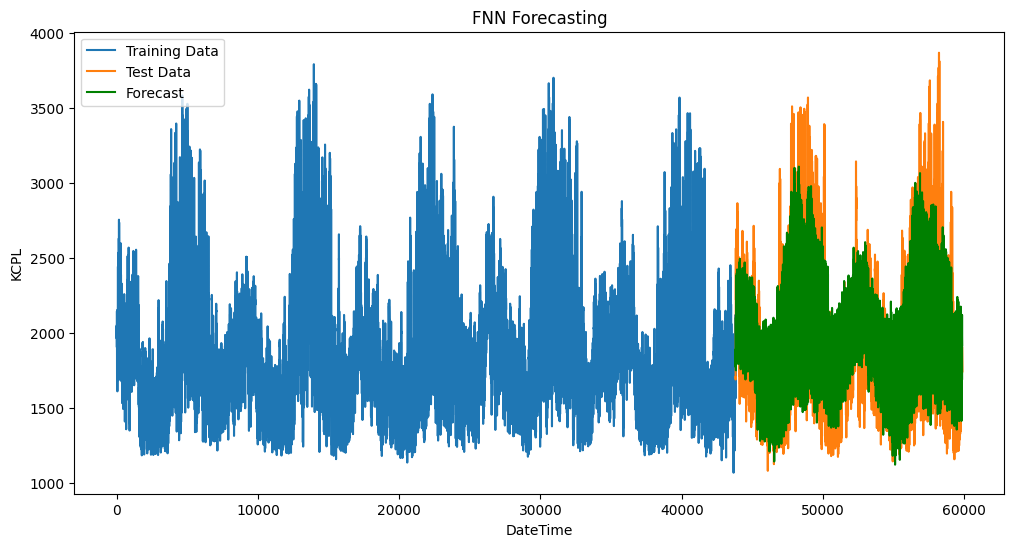

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, target_train, label='Training Data')
plt.plot(df_test.index + df_train.shape[0], target_test, label='Test Data')
plt.plot(df_test.index + df_train.shape[0], y_pred, label='Forecast', color='green')
plt.title('FNN Forecasting')
plt.xlabel('DateTime')
plt.ylabel('KCPL')
plt.legend()
plt.show()